In [1]:
from __future__ import print_function
import importlib
resources = importlib.import_module("resources")
import resources.MonteCarlo as MC

import numpy as np
import pandas as pd
import random
random.seed(2010)

import matplotlib.pyplot as plt
%matplotlib inline 

import keras
import tensorflow as tf
from keras.layers import Dense, BatchNormalization, Multiply, Lambda, LeakyReLU
from keras.models import Model
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from keras import backend as K

Using TensorFlow backend.


In [2]:
normalization_const = 1e7

#Import Data
Data = pd.read_csv('data/preprocessedlosAngParking/part-00000-a8814381-7490-4ac5-8769-145ad7e2824a-c000.csv').sample(frac = 1/1000)
Data['SN'] = pd.to_numeric(Data['SN'], errors ='coerce')
Data['position'] = pd.to_numeric(Data['position'], errors ='coerce')
Data.dropna()
Data = Data[Data['SN'] > 1.3e9]
Data = Data/normalization_const
X = Data['SN'].values
Y = Data['position'].values

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
from keras.callbacks import ModelCheckpoint

batch_size = 256
no_input  = 1
epochs = 15000
lambd  = 1e-3

results = {}
models  = []
no_output_range = range(4,10)
def customLoss(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return K.sum(K.min(K.square(yTrue - yPred),axis = 0))\
    +lambd*K.sum(K.square(yTrue-yPred))

def customMetric(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return K.max(K.min(K.abs(yTrue -yPred),axis = 0))

for no_output in no_output_range:
    neg_pos_mask = tf.constant(np.random.choice( [-1,1],[1,no_output]),dtype = tf.float32)
    
    _input_= keras.layers.Input(shape=(no_input,))
    
    #mask = Lambda( lambda x : neg_pos_mask)(_input_) # _input_ is just added to get this to compile
    l1 = Dense(64, activation='linear',
                    kernel_initializer= RandomNormal(), bias_initializer='zeros',
                    kernel_constraint=NonNeg(),                   
                    input_shape=[no_input])(_input_)
    l1a =keras.layers.LeakyReLU(alpha=0.1)(l1)
    l1b = BatchNormalization()(l1a)
    l2 = Dense(64, activation='linear',
                    kernel_initializer=RandomNormal(), bias_initializer='zeros',
                    kernel_constraint=NonNeg())(l1b)
    l2b =keras.layers.LeakyReLU(alpha=0.1)(l2)    
    l3 = Dense(no_output, activation='linear',
                    kernel_initializer=RandomNormal(), bias_initializer='zeros',
                    kernel_constraint=NonNeg())(l2b)

    _output_ =l3
    #_output_ = Multiply()([l3,mask])
    
    model = keras.models.Model(inputs=_input_ , outputs=_output_)
    filepath = "results\parking_weights{}.hdf5".format(no_output)
    checkpoint = ModelCheckpoint(filepath, monitor="val_customMetric", verbose=0, mode = 'min', save_best_only=True)
    model.compile(loss=customLoss, metrics=[customMetric],
                  optimizer=keras.optimizers.Nadam(lr=.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.0001))
    model.fit(X, Y,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X, Y),
              callbacks=[checkpoint],
              verbose=0)
    model.load_weights(filepath)    
    score = model.evaluate(X, Y, verbose=0)
    print(score)
    YPred= model.predict(X)
    maxError = np.max(np.min(np.abs(YPred - Y.reshape(Y.shape[0],1)),axis=1),axis=0)
    results[no_output] = maxError
    models.append(model)
print(results)

[0.009765769384233914, 0.007057405399977399]
[0.010465194864774425, 0.008864821780263137]
[0.014734461957169306, 0.01188405623022897]
[0.01373665518902332, 0.009528346951678804]
[0.057334067317865556, 0.00584053827153025]
[0.021172793099366847, 0.00848234454556268]
{4: 0.8693635560821533, 5: 0.7642270423721313, 6: 0.48663241220550535, 7: 0.682504782850647, 8: 1.2165749170135498, 9: 0.6010561438545227}


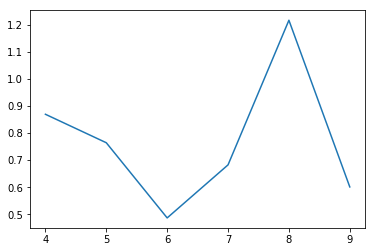

In [5]:
plt.plot(results.keys(),results.values())

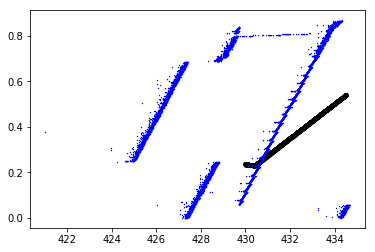

In [6]:
X_space = np.linspace(430, 434.5, 400)
#Y1,Y2 = zip(*model.predict(X))
i = 0 
for model in models:
    i+=1
    plt.clf()
    model_output_linspace = zip(*model.predict(X_space))

    plt.scatter(X, Y,s = .2, c='blue',marker= '^',zorder=2)
    #plt.scatter(x_test, y_test, s = .2 ,c='black',zorder=2)

    for Y_pred in model_output_linspace:
        line, = plt.plot(X_space,Y_pred, '.b',linewidth = 1,zorder=1)
        line.set_color("black")
    #plt.plot(X,Y3, 'b-',linewidth = 3)
    #plt.plot(X,Y4, 'y-',linewidth = 3)

    #plt.ylim(0,100)
    # Add title and x, y labels
    plt.savefig("results/Test_Parking_{number}.jpg".format(number = i))


In [68]:
print(X.shape)
print(Y.shape)
X.transpose()-Y.values

(2, 410)
(410,)


ValueError: operands could not be broadcast together with shapes (410,2) (410,) 

In [66]:
m=(np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11]]))

v = pd.Series(np.array([0, 1, 2]))
print(v.shape)
print(m.shape)
print(m-v)

(3,)
(4, 3)


ValueError: Length of passed values is 4, index implies 3

In [47]:
def TestcustomMetric(yTrue,yPred):
    #return K.sum(K.square(yTrue-yPred))
    return np.max(np.min(np.abs(np.repeat(yTrue.reshape((Y.shape[0],1)),2,axis=1) -yPred),axis = 1))

TestcustomMetric(Y,model.predict(X))

0.1866734155456543

In [18]:
np.max(np.min(np.abs(Y-model.predict(X).transpose()),axis =0))


0.8146390024841309